# Building a search index
The goal of this notebook is to build a search index on top of the **all_sources_metadata file**. This csv file contains information on all the papers in the CORD dataset, though for a proportion of the papers this information is sparse/incomplete. Regardless, the search index will work in any case, while there are ways to fix the metadata limitation.

There are 29500 papers in the dataset. These are listed in the all_sources_metadata file. 

Some of the papers in the metadata are also in JSON files. The eventual goal is to connect the metadata with the JSON data.


## Features of this notebook
This notebook has the following useful features
1. Viewing the papers in the metdata csv as a dataframe
2. Selecting individual papers
3. Search using a simple search index using **RankBM25**
4. Autocomplete search bar

The image below shows one of the features of this notebook - the ability to select the papers in the dataset that are relevant to a given task. In this case we are selecting papers about **ethical** and **social concerns**.

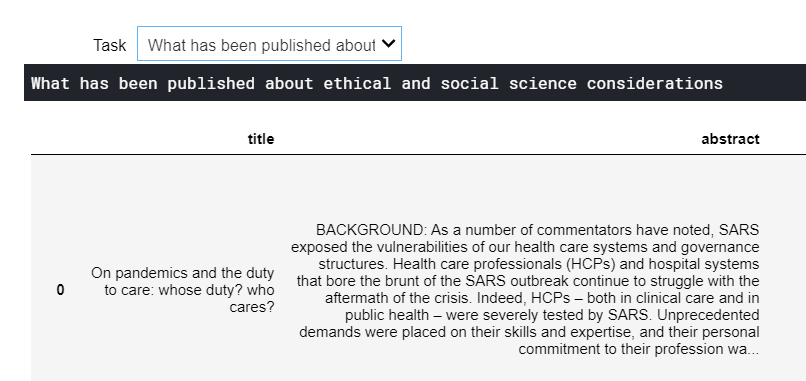

In [1]:
from IPython.display import Image
Image("../input/ethics/ethics.png")

The notebook leads up to creating a working search index and search bar

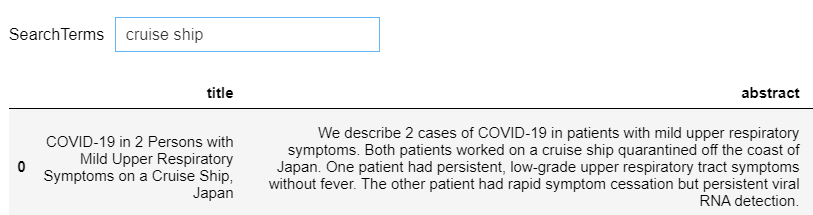

In [2]:
Image("../input/searchbar/searchbar.png")

# Before we begin
### a. Turn Internet ON
This notebook runs code that assume that the **Internet** is **ON**. Make sure to turn Internet to ON in the notebook **Settings**

### b. Install software

In [3]:
!pip install rank_bm25 nltk

  Created wheel for rank-bm25: filename=rank_bm25-0.2-py3-none-any.whl size=4161 sha256=115da8a5912ca82c79494cdf2e99ef59c579d00898b71c655616ada510867664
  Stored in directory: /root/.cache/pip/wheels/82/a9/a2/33d3c389435f63f6fa490ef91417c997ccc4e7db75f5a7b2f8
Successfully built rank-bm25


### c. Import Libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path, PurePath
import pandas as pd
import requests
from requests.exceptions import HTTPError, ConnectionError
from ipywidgets import interact
import ipywidgets as widgets
from rank_bm25 import BM25Okapi
import nltk
from nltk.corpus import stopwords
nltk.download("punkt")
import re

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### d. Adjust Notebook display settings
To change the width of the pandas dataframe columns - useful when we a displaying text in a dataframe, we can adjust the pandas display settings.

In [5]:
from ipywidgets import interact
import ipywidgets as widgets
import pandas as pd

def set_column_width(ColumnWidth, MaxRows):
    pd.options.display.max_colwidth = ColumnWidth
    pd.options.display.max_rows = MaxRows
    print('Set pandas dataframe column width to', ColumnWidth, 'and max rows to', MaxRows)
    
interact(set_column_width, 
         ColumnWidth=widgets.IntSlider(min=50, max=400, step=50, value=200),
         MaxRows=widgets.IntSlider(min=50, max=500, step=100, value=100));

Set pandas dataframe column width to 200 and max rows to 100


# 1. Load the All Sources Metadata file
Here we load the csv file containing the metadata for the SARS-COV-2 papers.

In [6]:
# Where are all the files located
input_dir = PurePath('../input/CORD-19-research-challenge/2020-03-13')

# The all sources metadata file
metadata = pd.read_csv(input_dir / 'all_sources_metadata_2020-03-13.csv', 
                      dtype={'Microsoft Academic Paper ID': str,
                             'pubmed_id': str})

# Convert the doi to a url
def doi_url(d): return f'http://{d}' if d.startswith('doi.org') else f'http://doi.org/{d}'
metadata.doi = metadata.doi.fillna('').apply(doi_url)

# Set the abstract to the paper title if it is null
metadata.abstract = metadata.abstract.fillna(metadata.title)

In [7]:
len(metadata)

29500

### Drop duplicate papers

In [8]:
# Some papers are duplicated since they were collected from separate sources. Thanks Joerg Rings
duplicate_paper = ~(metadata.title.isnull() | metadata.abstract.isnull()) & (metadata.duplicated(subset=['title', 'abstract']))
metadata = metadata[~duplicate_paper].reset_index(drop=True)

In [9]:
len(metadata)

25133

# 2. Create Data Classes for the Research Dataset and Papers
These classes make it easier to navigate through the datasources. There is a class called **ResearchPapers** that wraps the entire dataset an provide useful functions to navigate through it, and **Paper**, that make it easier to view each paper.

In [10]:
def get(url, timeout=6):
    try:
        r = requests.get(url, timeout=timeout)
        return r.text
    except ConnectionError:
        print(f'Cannot connect to {url}')
        print(f'Remember to turn Internet ON in the Kaggle notebook settings')
    except HTTPError:
        print('Got http error', r.status, r.text)

class DataHolder:
    '''
    A wrapper for a dataframe with useful functions for notebooks
    '''
    def __init__(self, data: pd.DataFrame):
        self.data = data
        
    def __len__(self): return len(self.data)
    def __getitem__(self, item): return self.data.loc[item]
    def head(self, n:int): return DataHolder(self.data.head(n).copy())
    def tail(self, n:int): return DataHolder(self.data.tail(n).copy())
    def _repr_html_(self): return self.data._repr_html_()
    def __repr__(self): return self.data.__repr__()


class ResearchPapers:
    
    def __init__(self, metadata: pd.DataFrame):
        self.metadata = metadata
        
    def __getitem__(self, item):
        return Paper(self.metadata.iloc[item])
    
    def __len__(self):
        return len(self.metadata)
    
    def head(self, n):
        return ResearchPapers(self.metadata.head(n).copy().reset_index(drop=True))
    
    def tail(self, n):
        return ResearchPapers(self.metadata.tail(n).copy().reset_index(drop=True))
    
    def abstracts(self):
        return self.metadata.abstract.dropna()
    
    def titles(self):
        return self.metadata.title.dropna()
        
    def _repr_html_(self):
        return self.metadata._repr_html_()
    
class Paper:
    
    '''
    A single research paper
    '''
    def __init__(self, item):
        self.paper = item.to_frame().fillna('')
        self.paper.columns = ['Value']
    
    def doi(self):
        return self.paper.loc['doi'].values[0]
    
    def html(self):
        '''
        Load the paper from doi.org and display as HTML. Requires internet to be ON
        '''
        text = get(self.doi())
        return widgets.HTML(text)
    
    def text(self):
        '''
        Load the paper from doi.org and display as text. Requires Internet to be ON
        '''
        text = get(self.doi())
        return text
    
    def abstract(self):
        return self.paper.loc['abstract'].values[0]
    
    def title(self):
        return self.paper.loc['title'].values[0]
    
    def authors(self, split=False):
        '''
        Get a list of authors
        '''
        authors = self.paper.loc['authors'].values[0]
        if not authors:
            return []
        if not split:
            return authors
        if authors.startswith('['):
            authors = authors.lstrip('[').rstrip(']')
            return [a.strip().replace("\'", "") for a in authors.split("\',")]
        
        # Todo: Handle cases where author names are separated by ","
        return [a.strip() for a in authors.split(';')]
        
    def _repr_html_(self):
        return self.paper._repr_html_()
    

papers = ResearchPapers(metadata)

### Authors

In [11]:
papers[1620].authors(split=True)

['Wang, Zheng',
 'Malanoski, Anthony P',
 'Lin, Baochuan',
 'Kidd, Carolyn',
 'Long, Nina C',
 'Blaney, Kate M',
 'Thach, Dzung C',
 'Tibbetts, Clark',
 'Stenger, David A']

## Examples of Loading a Paper from DOI

To run the code below the **Internet** must be set to **ON**. This setting is on the **right pane** or at the **bottom****** of the notebook.

### Show a paper

In [12]:
papers[0]

,Value
sha,c630ebcdf30652f0422c3ec12a00b50241dc9bd9
source_x,CZI
title,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target
doi,http://doi.org/10.1007/s00134-020-05985-9
pmcid,
pubmed_id,32125455
license,cc-by-nc
abstract,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target
publish_time,2020
authors,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; Zhong, Nanshan; Slutsky, Arthur S."


### Load a paper
The following code loads the **doi** url and displays it inside an **ipywidget HTML widget**. 
Note that there seems to be a side effect on some papers where the notebook takes the CSS style of the research paper. I am looking into this.

In [13]:
papers[0].html()

HTML(value='<!DOCTYPE html>\n<html lang="en" class="no-js">\n<head>\n    <meta charset="UTF-8"/>\n    <meta ht…

### Load a paper as text

In [14]:
papers[0].text()[:1000]

'<!DOCTYPE html>\n<html lang="en" class="no-js">\n<head>\n    <meta charset="UTF-8"/>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <meta name="access" content="Yes">\n    \n\n    <meta name="journal_id" content="134"/>\n\n    <meta name="dc.title" content="Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target"/>\n\n    <meta name="dc.source" content="Intensive Care Medicine 2020"/>\n\n    <meta name="dc.format" content="text/html"/>\n\n    <meta name="dc.publisher" content="Springer"/>\n\n    <meta name="dc.date" content="2020-03-03"/>\n\n    <meta name="dc.type" content="BriefCommunication"/>\n\n    <meta name="dc.language" content="En"/>\n\n    <meta name="dc.copyright" content="2020 The Author(s)"/>\n\n    <meta name="dc.rightsAgent" content="journalpermissions@springernature.com"/>\n\n    <meta name="dc.description" content="

## Select the first 2 papers

In [15]:
papers.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target,http://doi.org/10.1007/s00134-020-05985-9,NaN,32125455,cc-by-nc,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; Zhong, Nanshan; Slutsky, Arthur S.",Intensive Care Med,2002765492,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coronavirus (2019-nCoV/SARS-CoV-2) receptor ACE2 in different populations,http://doi.org/10.1038/s41421-020-0147-1,NaN,NaN,cc-by,Comparative genetic analysis of the novel coronavirus (2019-nCoV/SARS-CoV-2) receptor ACE2 in different populations,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengqing; Huang, Peide; Sun, Xiaohui; Wen, Fang; Huang, Xuanlin; Ning, Guang; Wang, Weiqing",Cell Discovery,3003430844,#1861,True


## Abstracts

In [16]:
papers.head(2).abstracts()

0    Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target
1       Comparative genetic analysis of the novel coronavirus (2019-nCoV/SARS-CoV-2) receptor ACE2 in different populations
Name: abstract, dtype: object

## Titles
Show the titles of the first 2 papers

In [17]:
papers.head(2).titles()

0    Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target
1       Comparative genetic analysis of the novel coronavirus (2019-nCoV/SARS-CoV-2) receptor ACE2 in different populations
Name: title, dtype: object

# 3. Creating a search index
We will create a simple search index that will just match search tokens in a document. First we tokenize the abstract and store it in a dataframe. Then we just match search terms against it.

In [18]:
from rank_bm25 import BM25Okapi

Note that below I had created a **WordTokenIndex** which can still be used, I have since moved on to the **RankBM25Index** in the cell below it. (This will be refactored)

### Text Preprocessing
To prepare the text for the search index we perform the following steps
1. Remove punctuations and special characters
2. Convert to lowercase
3. Tokenize into individual tokens (words mostly)
4. Remove stopwords like (and, to))

You can tweak the code below to improve the search results

In [19]:
english_stopwords = list(set(stopwords.words('english')))

def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

def clean(text):
    t = text.lower()
    t = strip_characters(t)
    return t

def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(set([word for word in words 
                     if len(word) > 1
                     and not word in english_stopwords
                     and not (word.isnumeric() and len(word) is not 4)
                     and (not word.isnumeric() or word.isalpha())] )
               )

def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    return tokens

class SearchResults:
    
    def __init__(self, 
                 data: pd.DataFrame,
                 columns = None):
        self.results = data
        if columns:
            self.results = self.results[columns]
            
    def __getitem__(self, item):
        return Paper(self.results.loc[item])
    
    def __len__(self):
        return len(self.results)
        
    def _repr_html_(self):
        return self.results._repr_html_()

SEARCH_DISPLAY_COLUMNS = ['title', 'abstract', 'doi', 'authors', 'journal']

class WordTokenIndex:
    
    def __init__(self, 
                 corpus: pd.DataFrame, 
                 columns=SEARCH_DISPLAY_COLUMNS):
        self.corpus = corpus
        raw_search_str = self.corpus.abstract.fillna('') + ' ' + self.corpus.title.fillna('')
        self.index = raw_search_str.apply(preprocess).to_frame()
        self.index.columns = ['terms']
        self.index.index = self.corpus.index
        self.columns = columns
    
    def search(self, search_string):
        search_terms = preprocess(search_string)
        result_index = self.index.terms.apply(lambda terms: any(i in terms for i in search_terms))
        results = self.corpus[result_index].copy().reset_index().rename(columns={'index':'paper'})
        return SearchResults(results, self.columns + ['paper'])

## Using a RankBM25 Search Index

RankBM25 is a python library that implements algorithms for a simple search index.
https://pypi.org/project/rank-bm25/

In [20]:
class RankBM25Index(WordTokenIndex):
    
    def __init__(self, corpus: pd.DataFrame, columns=SEARCH_DISPLAY_COLUMNS):
        super().__init__(corpus, columns)
        self.bm25 = BM25Okapi(self.index.terms.tolist())
        
    def search(self, search_string, n=4):
        search_terms = preprocess(search_string)
        doc_scores = self.bm25.get_scores(search_terms)
        ind = np.argsort(doc_scores)[::-1][:n]
        results = self.corpus.iloc[ind][self.columns]
        results['Score'] = doc_scores[ind]
        results = results[results.Score > 0]
        return SearchResults(results.reset_index(), self.columns + ['Score'])
    
bm25 = RankBM25Index(metadata.head(100))
bm25.search('cruise')

,title,abstract,doi,authors,journal,Score
0,Backcalculating the Incidence of Infection with COVID-19 on the Diamond Princess,"To understand the time-dependent risk of infection on a cruise ship, the Diamond Princess, I estimated the incidence of infection with novel coronavirus (COVID-19). The epidemic curve of a total o...",http://doi.org/10.3390/jcm9030657,"Nishiura, Hiroshi",J Clin Med,3.303773
1,Estimation of the reproductive number of Novel Coronavirus (COVID-19) and the probable outbreak size on the Diamond Princess cruise ship: A data-driven analysis,"Backgrounds Up to February 16, 2020, 355 cases have been confirmed as having COVID-19 infection on the Diamond Princess cruise ship. It is of crucial importance to estimate the reproductive number...",http://doi.org/10.1016/j.ijid.2020.02.033,"Zhang, Sheng; Diao, MengYuan; Yu, Wenbo; Pei, Lei; Lin, Zhaofen; Chen, Dechang",International Journal of Infectious Diseases,2.635377
2,COVID-19 outbreak on the Diamond Princess cruise ship: estimating the epidemic potential and effectiveness of public health countermeasures,"Cruise ships carry a large number of people in confined spaces with relative homogeneous mixing. On 3 February, 2020, an outbreak of COVID-19 on cruise ship Diamond Princess was reported with 10 i...",http://doi.org/10.1093/jtm/taaa030,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,2.477118


### Search for sars-cov-2

In [21]:
bm25.search('sars-cov-2')

,title,abstract,doi,authors,journal,Score
0,SARS-CoV-2 infection in children: Transmission dynamics and clinical characteristics,SARS-CoV-2 infection in children: Transmission dynamics and clinical characteristics,http://doi.org/10.1016/j.jfma.2020.02.009,"Cao, Qing; Chen, Yi-Ching; Chen, Chyi-Liang; Chiu, Cheng-Hsun",Journal of the Formosan Medical Association,2.617278
1,A potential role for integrins in host cell entry by SARS-CoV-2,A potential role for integrins in host cell entry by SARS-CoV-2,http://doi.org/10.1016/j.antiviral.2020.104759,"Sigrist, Christian; Bridge, Alan; Le Mercier, Philippe",Antiviral Research,2.617278
2,"Differential diagnosis of illness in patients under investigation for the novel coronavirus (SARS-CoV-2), Italy, February 2020","Differential diagnosis of illness in patients under investigation for the novel coronavirus (SARS-CoV-2), Italy, February 2020",http://doi.org/10.2807/1560-7917.ES.2020.25.8.2000170,"Bordi, Licia; Nicastri, Emanuele; Scorzolini, Laura; Caro, Antonino Di; Capobianchi, Maria Rosaria; Castilletti, Concetta; Lalle, Eleonora; group, on behalf of INMI COVID-19 study; Centers2, Colla...",Eurosurveillance,2.531772
3,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target,Angiotensin-converting enzyme 2 (ACE2) as a SARS-CoV-2 receptor: molecular mechanisms and potential therapeutic target,http://doi.org/10.1007/s00134-020-05985-9,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; Zhong, Nanshan; Slutsky, Arthur S.",Intensive Care Med,2.531772


## The Search Index

Creating a search index on the entire dataset takes over a minute. As a todo I will try to speed it up.
For now let's create the search index on the first 10000 records

In [22]:
bm25_index = RankBM25Index(metadata.head(10000))

In [23]:
results = bm25_index.search('cruise ship')
results

,title,abstract,doi,authors,journal,Score
0,"COVID-19 in 2 Persons with Mild Upper Respiratory Symptoms on a Cruise Ship, Japan","We describe 2 cases of COVID-19 in patients with mild upper respiratory symptoms. Both patients worked on a cruise ship quarantined off the coast of Japan. One patient had persistent, low-grade up...",http://doi.org/10.3201/eid2606.200452,"Arashiro, Takeshi; Furukawa, Keiichi; Nakamura, Akira",Emerging infectious diseases,19.385942
1,From the frontlines of COVID-19 – How prepared are we as obstetricians: a commentary,Abstract The World Health Organization (WHO) has declared the outbreak of novel coronavirus (2019-nCoV) ? now known as Coronavirus Disease (COVID-19)1 - as a global health emergency. Singapore cur...,http://doi.org/10.1111/1471-0528.16192,"Chua, Monica Shi Qi; Lee, Jill Cheng Sim; Sulaiman, Suzanna; Tan, Hak Koon",BJOG: An International Journal of Obstetrics & Gynaecology,18.493471
2,COVID-19—New Insights on a Rapidly Changing Epidemic,"Since first reported in Wuhan, China, in late December 2019, the outbreak of the novel coronavirus now known as SARS-CoV-2 (severe acute respiratory syndrome coronavirus 2) has spread globally. As...",http://doi.org/10.1001/jama.2020.3072,"del Rio, Carlos; Malani, Preeti N.",JAMA,17.679557
3,Backcalculating the Incidence of Infection with COVID-19 on the Diamond Princess,"To understand the time-dependent risk of infection on a cruise ship, the Diamond Princess, I estimated the incidence of infection with novel coronavirus (COVID-19). The epidemic curve of a total o...",http://doi.org/10.3390/jcm9030657,"Nishiura, Hiroshi",J Clin Med,15.195554


### Show the paper for the 4th item in the search results

In [24]:
results[3].title()

'Backcalculating the Incidence of Infection with COVID-19 on the Diamond Princess'

# 4. Looking at the Covid Research Tasks
This dataset has a number of tasks. We will try to organize the papers according to the tasks

1. **What is known about transmission, incubation, and environmental stability?**
2. **What do we know about COVID-19 risk factors?**
3. **What do we know about virus genetics, origin, and evolution?**
4. **What has been published about ethical and social science considerations?**
5. **What do we know about diagnostics and surveillance?**
6. **What has been published about medical care?**
7. **What do we know about non-pharmaceutical interventions?**
8. **What has been published about information sharing and inter-sectoral collaboration?**
9. **What do we know about vaccines and therapeutics?**

In [25]:
tasks = [('What is known about transmission, incubation, and environmental stability?', 
        'transmission incubation environment coronavirus'),
        ('What do we know about COVID-19 risk factors?', 'risk factors'),
        ('What do we know about virus genetics, origin, and evolution?', 'genetics origin evolution'),
        ('What has been published about ethical and social science considerations','ethics ethical social'),
        ('What do we know about diagnostics and surveillance?','diagnose diagnostic surveillance'),
        ('What has been published about medical care?', 'medical care'),
        ('What do we know about vaccines and therapeutics?', 'vaccines vaccine vaccinate therapeutic therapeutics')] 
tasks = pd.DataFrame(tasks, columns=['Task', 'Keywords'])

## Research Papers for each task
Here we add a dropdown that allows for selection of tasks and show the search results.

In [26]:
def show_task(Task):
    print(Task)
    keywords = tasks[tasks.Task == Task].Keywords.values[0]
    search_results = bm25_index.search(keywords, n=200)
    return search_results
    
results = interact(show_task, Task = tasks.Task.tolist());

What is known about transmission, incubation, and environmental stability?


,title,abstract,doi,authors,journal,Score
0,A familial cluster of infection associated with the 2019 novel coronavirus indicating potential person-to-person transmission during the incubation period,"An ongoing outbreak of pneumonia associated with 2019 novel coronavirus (2019-nCoV) was reported in China. It is unclear if the infectivity exists during the incubation period, although a person-t...",http://doi.org/10.1093/infdis/jiaa077,"Yu, Ping; Zhu, Jiang; Zhang, Zhengdong; Han, Yingjun; Huang, Lihong",The Journal of Infectious Diseases,10.535028
1,Emergency management for preventing and controlling nosocomial infection of 2019 novel coronavirus: implications for the dermatology department,"Summary As of Feb 15, 2019, the novel coronavirus (2019-nCoV) has rapidly spread throughout China and across the world with more than 60,000 laboratory-confirmed cases. Due to the current lack of ...",http://doi.org/10.1111/bjd.19011,"Tao, J.; Song, Z.; Yang, L.; Huang, C.; Feng, A.; Man, X.",British Journal of Dermatology,10.219705
2,Technologies and requirements of protection and disinfection in key places during the novel coronavirus pneumonia (NCP) outbreak,"Novel coronavirus pneumonia (NCP), a new respiratory infectious disease, has become an important public health problem. Inappropriate protection and disinfection measures are potential risk factor...",http://doi.org/10.3760/cma.j.cn112150-20200217-00131,"Novel Coronavirus Pneumonia Emergency Response Key Places, Protection; Disinfection Technology Team, Chinese Center for Disease Control; Prevention",Zhonghua Yu Fang Yi Xue Za Zhi,8.831295
3,Serial interval of novel coronavirus (COVID-19) infections,Objective To estimate the serial interval of novel coronavirus (COVID-19) from information on 28 infector-infectee pairs. Methods We collected dates of illness onset for primary cases (infectors) ...,http://doi.org/10.1016/j.ijid.2020.02.060,"Nishiura, Hiroshi; Linton, Natalie M.; Akhmetzhanov, Andrei R.",International Journal of Infectious Diseases,8.620067
4,"Estimating the incubation period of hand, foot and mouth disease for children in different age groups","Hand, foot and mouth disease (HFMD) is a childhood disease causing large outbreaks frequently in Asia and occasionally in Europe and the US. The incubation period of HFMD was typically described a...",http://doi.org/http://dx.doi.org/10.1038/s41598-017-16705-7,"['Yang, Zhongzhou', 'Zhang, Qiqi', 'Cowling, Benjamin J.', 'Lau, Eric H. Y.']",Sci Rep,8.591348
...,...,...,...,...,...,...
195,The transmission and diagnosis of 2019 novel coronavirus infection disease (COVID-19): A Chinese perspective,"2019 novel coronavirus (SARS-CoV-2), which originated in Wuhan, China, has attracted the world's attention over the last month. The Chinese government has taken emergency measures to control the o...",http://doi.org/10.1002/jmv.25749,"Han, Y.; Yang, H.",Journal of medical virology,4.259368
196,Investigation of serum protein profiles in scrapie infected sheep by means of SELDI-TOF-MS and multivariate data analysis,"BACKGROUND: Classical scrapie in sheep is a fatal neurodegenerative disease associated with the conversion PrP(C) to PrP(Sc). Much is known about genetic susceptibility, uptake and dissemination o...",http://doi.org/http://dx.doi.org/10.1186/1756-0500-6-466,"['Meling, Siv', 'Kvalheim, Olav M', 'Arneberg, Reidar', 'Bårdsen, Kjetil', 'Hjelle, Anne', 'Ulvund, Martha J']",BMC Res Notes,4.253862
197,Chinese expert consensus on the perinatal and neonatal management for the prevention and control of the 2019 novel coronavirus infection (First edition),"Since December 2019, there has been an outbreak of novel coronavirus (2019-nCoV) infection in China. Two cases of neonates with positive 2019-nCoV tests have been reported. Due to the immature imm...",http://doi.org/10.21037/atm.2020.02.20,"Wang, Laishuan; Shi, Yuan; Xiao, Tiantian; Fu, Jianhua; Feng, Xing; Mu, Dezhi; Feng, Qi; Hei, Mingyan; Hu, Xiaojing; Li, Zhankui; Lu, Guoping; Tang,

# 5. Creating an Autocomplete Search bar
Here we provide a search bar with autocomplete. This uses IPywidgets **interactive** rendering of a **TextBox**.


In [27]:
from IPython.display import display

def search_papers(SearchTerms: str):
    search_results = bm25_index.search(SearchTerms, n=10)
    if len(search_results) > 0:
        display(search_results) 
    return search_results

searchbar = widgets.interactive(search_papers, SearchTerms='cruise ship')
searchbar

,title,abstract,doi,authors,journal,Score
0,"COVID-19 in 2 Persons with Mild Upper Respiratory Symptoms on a Cruise Ship, Japan","We describe 2 cases of COVID-19 in patients with mild upper respiratory symptoms. Both patients worked on a cruise ship quarantined off the coast of Japan. One patient had persistent, low-grade up...",http://doi.org/10.3201/eid2606.200452,"Arashiro, Takeshi; Furukawa, Keiichi; Nakamura, Akira",Emerging infectious diseases,19.385942
1,From the frontlines of COVID-19 – How prepared are we as obstetricians: a commentary,Abstract The World Health Organization (WHO) has declared the outbreak of novel coronavirus (2019-nCoV) ? now known as Coronavirus Disease (COVID-19)1 - as a global health emergency. Singapore cur...,http://doi.org/10.1111/1471-0528.16192,"Chua, Monica Shi Qi; Lee, Jill Cheng Sim; Sulaiman, Suzanna; Tan, Hak Koon",BJOG: An International Journal of Obstetrics & Gynaecology,18.493471
2,COVID-19—New Insights on a Rapidly Changing Epidemic,"Since first reported in Wuhan, China, in late December 2019, the outbreak of the novel coronavirus now known as SARS-CoV-2 (severe acute respiratory syndrome coronavirus 2) has spread globally. As...",http://doi.org/10.1001/jama.2020.3072,"del Rio, Carlos; Malani, Preeti N.",JAMA,17.679557
3,Backcalculating the Incidence of Infection with COVID-19 on the Diamond Princess,"To understand the time-dependent risk of infection on a cruise ship, the Diamond Princess, I estimated the incidence of infection with novel coronavirus (COVID-19). The epidemic curve of a total o...",http://doi.org/10.3390/jcm9030657,"Nishiura, Hiroshi",J Clin Med,15.195554
4,Scientist decries ‘completely chaotic’ conditions on cruise ship Japan quarantined after viral outbreak | Science | AAAS,"SHARE Share on facebook 80 Share on twitter Share on linkedin Share on reddit 3 Share on mailto A port security officer at the Diamond Princess in Yokohama, Japan’s port. Passengers who tested neg...",http://doi.org/,"Normile, Dennis",NaN,13.917046
5,Estimation of the reproductive number of Novel Coronavirus (COVID-19) and the probable outbreak size on the Diamond Princess cruise ship: A data-driven analysis,"Backgrounds Up to February 16, 2020, 355 cases have been confirmed as having COVID-19 infection on the Diamond Princess cruise ship. It is of crucial importance to estimate the reproductive number...",http://doi.org/10.1016/j.ijid.2020.02.033,"Zhang, Sheng; Diao, MengYuan; Yu, Wenbo; Pei, Lei; Lin, Zhaofen; Chen, Dechang",International Journal of Infectious Diseases,12.606774
6,An epidemiological study of rates of illness in passengers and crew at a busy Caribbean cruise port,"BACKGROUND: The Caribbean has one of the largest cruise ship industries in the world, with close to 20 million visitors per year. The potential for communicable disease outbreaks on vessels and th...",http://doi.org/http://dx.doi.org/10.1186/s12889-016-2991-3,"['Marshall, Cathy Ann', 'Morris, Euclid', 'Unwin, Nigel']",BMC Public Health,12.494740
7,COVID-19 outbreak on the Diamond Princess cruise ship: estimating the epidemic potential and effectiveness of public health countermeasures,"Cruise ships carry a large number of people in confined spaces with relative homogeneous mixing. On 3 February, 2020, an outbreak of COVID-19 on cruise ship Diamond Princess was reported with 10 i...",http://doi.org/10.1093/jtm/taaa030,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,11.963165
8,Backcalculating the Incidence of Infection with COVID-19 on the Diamond Princess Comparative Seasonal Respiratory Virus Epidemic Timing in Utah,"To understand the time-dependent risk of infection on a cruise ship, the Diamond Princess, I estimated the incidence of infection with novel coronavirus (COVID-19). The epidemic curve of a total o...",http://doi.org/10.3390/jcm9030657 10.3390/v12030275,"Nishiura, Hiroshi; Callahan, Y. Zayne; Smith, K. Trevor; Ingersoll, Celeste; Gardner, Rebecca; Korgenski, K. E.; Sloan, D. Chante

## Access the search results
After a search is performed the search results is available in the **result** property. So we can display the list of results or an individual result as required.

In [28]:
searchbar.result[0]

,Value
title,"COVID-19 in 2 Persons with Mild Upper Respiratory Symptoms on a Cruise Ship, Japan"
abstract,"We describe 2 cases of COVID-19 in patients with mild upper respiratory symptoms. Both patients worked on a cruise ship quarantined off the coast of Japan. One patient had persistent, low-grade up..."
doi,http://doi.org/10.3201/eid2606.200452
authors,"Arashiro, Takeshi; Furukawa, Keiichi; Nakamura, Akira"
journal,Emerging infectious diseases
Score,19.3859


We can also access an individual result - once the result is populated

## A small contribution to the world from Canada

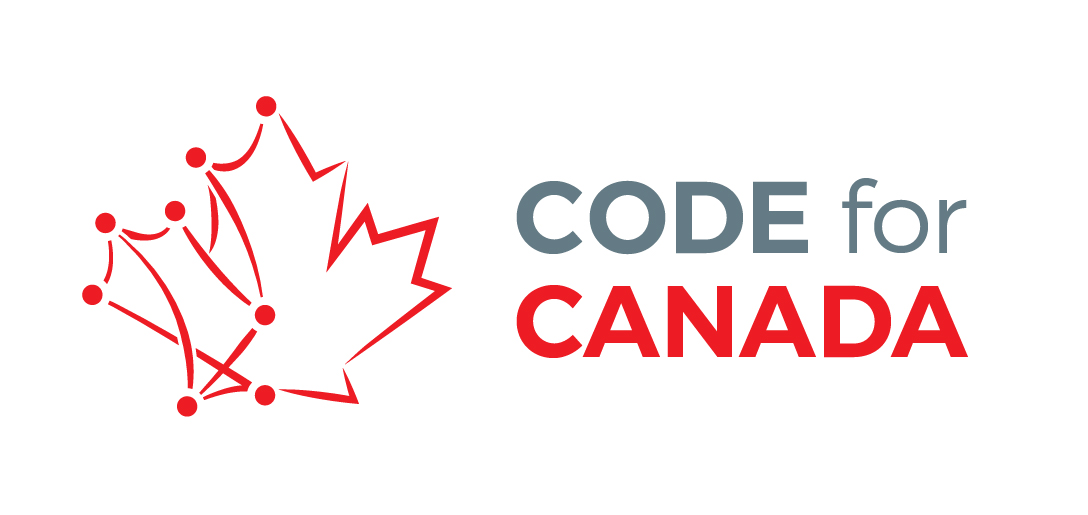

In [29]:
Image("../input/codeforcanada/code_for_canada.jpg")